In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
from prep import *
from features import *
from cross_validation import *
import light_gbm
import xg_boost
import extra_trees
from regmodel import *

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

unzip('/content/drive/My Drive/Colab Notebooks/test.zip')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def unzip(path):
    files = zf.ZipFile(path,'r')
    files.extractall()
    files.close()

In [ ]:
unzip("/content/drive/MyDrive/Colab Notebooks/test.zip")

In [ ]:
input_dir = "./test/"
output_dir = "./processed data/"

print("****************************** Load Data 2014-2017 ******************************")
df1 = create_features(input_dir, output_dir, 20140101, 20180101)
print("****************************** Load Data 2014-2018 ******************************")
df2 = create_features(input_dir, output_dir, 20140101, 20190101)

****************************** Load Data 2014-2017 ******************************
ret shape:  (2448284, 11)
Load data......elapsed time:  65.41080641746521 s......
missing_values_count:
 Date                              0
Time                              0
Id                                0
ResidualNoWinsorCumReturn         0
RawNoWinsorCumReturn              0
estVol                            0
SharesOutstanding                84
MDV_63                            6
CleanMid                     254473
CumVolume                    254473
IsOpen                       254473
dtype: int64
percent_missing:  2.8350432013160685
Fill missing data......elapsed time:  7.321627378463745 s......
Winsorize data......elapsed time:  47.01219177246094 s......
Save data......Finished......elapsed time:  32.52344560623169 s......
****************************** Load Data 2014-2018 ******************************
ret shape:  (3059576, 11)
Load data......elapsed time:  87.84741425514221 s......
missing_

In [ ]:
df1 = pd.read_csv("./processed data/features20140101_20180101.csv")
df2 = pd.read_csv("./processed data/features20140101_20190101.csv").drop(columns = ["Unnamed: 0"], axis = 1)

In [ ]:
df1 = pd.read_csv("./processed data/features20140101_20180101.csv")


In [ ]:
# Test data leakage
df1 = df1.set_index(["Date", "Id"])
df2 = df2.set_index(["Date", "Id"])

is_equal = (df1 - df2).dropna()
abs(is_equal).sum()

10/17res         0.0
10/17raw         0.0
16/17res         0.0
16/17raw         0.0
17ma1raw         0.0
17ma3raw         0.0
17ma5raw         0.0
17ma20raw        0.0
17ma1-3raw       0.0
17ma1-5raw       0.0
17ma1-20raw      0.0
17ma1res         0.0
17ma3res         0.0
17ma5res         0.0
17ma20res        0.0
17ma1-3res       0.0
17ma1-5res       0.0
17ma1-20res      0.0
market_value     0.0
10/17vol         0.0
16/17vol         0.0
turnover_ma1     0.0
turnover_ma3     0.0
turnover_ma5     0.0
turnover_ma20    0.0
estVol           0.0
cleanMid17       0.0
cleanMid16       0.0
cleanMid10       0.0
vol17            0.0
y                0.0
dtype: float64

***No Data Leakage***

## Train/Valid/Test Split

***Train: 2014-2017 data***

***Test: 2018 data***

In [204]:
# load train set from 2014-2016/2014-2017
train = df1.reset_index().drop(["Date", "Id"], axis = 1)
train = train[train['y'].notna()]

train141516 = df1.loc[df1.index.get_level_values("Date") < str(20170101)].reset_index().drop(["Date", "Id"], axis = 1)
train141516 = train141516[train141516['y'].notna()]
train17 = df1.loc[df1.index.get_level_values("Date") >= str(20170101)].reset_index().drop(["Date", "Id"], axis = 1)
train17 = train17[train17['y'].notna()]

# load test set 2017/2018
test = df2.loc[df2.index.get_level_values("Date") >= str(20180101)].reset_index().drop(["Date", "Id"], axis = 1)
test = test[test['y'].notna()]


# load target and features
X_train = train.iloc[:, :-1]
y_train = train['y']
X_test = test.iloc[:, :-1]
y_test = test['y']

X_train141516 = train141516.iloc[:, :-1]
y_train141516 = train141516['y']
X_train17 = train17.iloc[:, :-1]
y_train17 = train17['y']

## Feature Selection

In [ ]:
# vif filter
def calculateVIF(X):
    vif_data = pd.DataFrame({
        "Names": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_data

mtrain = X_train.copy()
vif = calculateVIF(mtrain)
while(vif["VIF"].max() >= 10):
    drop_var = vif[vif.VIF == vif["VIF"].max()]["Names"]
    print(drop_var)
    mtrain = mtrain.drop(drop_var, axis = 1)
    vif = calculateVIF(mtrain)
print(mtrain.columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


4        17ma1raw
5        17ma3raw
7       17ma20raw
8      17ma1-3raw
9      17ma1-5raw
11       17ma1res
15     17ma1-3res
16     17ma1-5res
17    17ma1-20res
Name: Names, dtype: object
18    cleanMid16
Name: Names, dtype: object
17    cleanMid17
Name: Names, dtype: object
14    turnover_ma5
Name: Names, dtype: object
13    turnover_ma3
Name: Names, dtype: object
11    16/17vol
Name: Names, dtype: object
Index(['10/17res', '10/17raw', '16/17res', '16/17raw', '17ma5raw',
       '17ma1-20raw', '17ma3res', '17ma5res', '17ma20res', 'market_value',
       '10/17vol', 'turnover_ma1', 'turnover_ma20', 'estVol', 'cleanMid10',
       'vol17'],
      dtype='object')


In [ ]:
# Backward Elimination
lr = LGBMRegressor()
sfs_initial = sfs(lr, k_features = 25, forward = False, verbose = 1, scoring = 'neg_mean_squared_error')
sfs_initial.fit(X_train.values, y_train.values)
print("Selected features:", sfs_initial.k_feature_names_)

In [ ]:
# Forward Elimination
lr = LGBMRegressor()
sfs_initial = sfs(lr, k_features = 25, forward = True, verbose = 1, scoring = 'neg_mean_squared_error')
sfs_initial.fit(X_train.values, y_train.values)
print("Selected features:", sfs_initial.k_feature_names_)

In [ ]:
X_train.columns

Index(['Unnamed: 0', '10/17res', '10/17raw', '16/17res', '16/17raw',
       '17ma1raw', '17ma3raw', '17ma5raw', '17ma20raw', '17ma1-3raw',
       '17ma1-5raw', '17ma1-20raw', '17ma1res', '17ma3res', '17ma5res',
       '17ma20res', '17ma1-3res', '17ma1-5res', '17ma1-20res', 'market_value',
       '10/17vol', '16/17vol', 'turnover_ma1', 'turnover_ma3', 'turnover_ma5',
       'turnover_ma20', 'estVol', 'cleanMid17', 'cleanMid16', 'cleanMid10',
       'vol17'],
      dtype='object')

In [ ]:
# use only selected features
selected_features_vif = ['10/17res', '10/17raw', '16/17res', '16/17raw', '17ma3raw', '17ma3res',
       '17ma5res', 'market_value', '10/17vol', '16/17vol', 'turnover_ma1',
       'turnover_ma20', 'estVol', 'cleanMid17', 'vol17']
selected_features_be = ['16/17res', '16/17raw', '17ma20raw', '17ma1-3raw', '17ma1-5raw',
       '17ma1res', '17ma3res', '17ma5res', '17ma20res', '17ma1-3res',
       '17ma1-5res', '17ma1-20res', 'market_value', '10/17vol', '16/17vol',
       'turnover_ma3', 'turnover_ma5', 'turnover_ma20', 'illiq17_y', 'MDV_63',
       'estVol', 'cleanMid17', 'cleanMid10', 'vol10',
       'ResidualNoWinsorCumReturn winsorized']
selected_features_fe = ['16/17res', '16/17raw', '17ma20raw', '17ma1-3raw', '17ma1-5raw',
      '17ma1res', '17ma3res', '17ma5res', '17ma20res', '17ma1-3res',
      '17ma1-5res', '17ma1-20res', 'market_value', '10/17vol', '16/17vol',
      'turnover_ma3', 'turnover_ma5', 'turnover_ma20', 'illiq17_y', 'MDV_63',
      'estVol', 'cleanMid17', 'cleanMid10', 'vol10',
      'ResidualNoWinsorCumReturn winsorized']

def select_features(method = "vif"):

    if method == "vif":
      selected_features = selected_features_vif
    elif method == "be":
      selected_features = selected_features_be
    elif method == "fe":
      selected_features = selected_features_fe
    else:
      return None
    
    return selected_features

In [ ]:
selected_features = select_features(method = "vif")
X_train = X_train[selected_features]
X_train141516 = X_train141516[selected_features]
X_test = X_test[selected_features]
X_train17 = X_train17[selected_features]

## Regression

In [ ]:
# normalize the data
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns).fillna(0)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns).fillna(0)

In [ ]:
# wide search
# ridge model
ridge_alphas = np.linspace(0, 100, 21)
regmodel.regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search')

In [ ]:
# wide search2
# ridge model
ridge_alphas = np.linspace(0, 10, 21)
regmodel.regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_wide_search2')

In [ ]:
# granular search
# ridge model
ridge_alphas = np.linspace(0, 1.5, 21)
chosen_alpha, _, _ = regmodel.regmodel_hyperparameter_tuning(ridge_alphas, X_train, y_train, 
                               n_splits = 5,  how_cv = "walk_forwarding", model_name = 'Ridge', X_test = X_test, y_test = y_test, 
                               draw_plot = True, filename = 'ridge_granular_search')

In [ ]:
# save ridge model
ridge_model = Ridge(alpha = chosen_alpha, fit_intercept = True)
ridge_model = ridge_model.fit(X_train, y_train)
pickle.dump(ridge_model, open("ridge.sav", 'wb'))

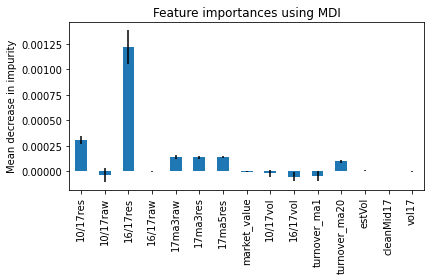

In [ ]:
perm = permutation_importance(ridge_model, X_test, y_test, n_repeats = 10, random_state = my_random_state)
ridge_importances = pd.Series(perm.importances_mean, index = X_test.columns.tolist())
std = perm.importances_std

fig, ax = plt.subplots()
ridge_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("feature_importance_ridge.jpg")

In [ ]:
# linear regreesion
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
r2_weight = 1 / X_test["estVol"]
print(r2_score(y_test, y_pred, sample_weight = r2_weight))
# save model
pickle.dump(lr_model, open("regmodel.sav", 'wb'))

0.001119135109870606


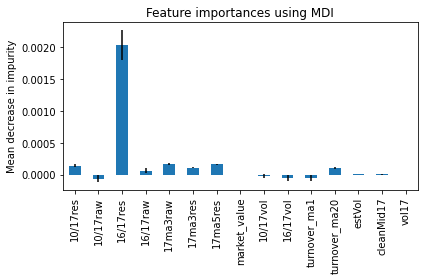

In [ ]:
perm = permutation_importance(lr_model, X_test, y_test, n_repeats = 10, random_state = my_random_state)
ridge_importances = pd.Series(perm.importances_mean, index = X_test.columns.tolist())
std = perm.importances_std

fig, ax = plt.subplots()
ridge_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.savefig("feature_importance_simpleLR.jpg")

## LightGBM

In [ ]:
permutations_lgb = { 'learning_rate': [0.05, 0.1],
                    'num_leaves': [24, 80],
                    'feature_fraction': [0.1, 0.9],
                    'bagging_fraction': [0.8, 1],
                    'max_depth': [5, 30]}
my_model = LGBMRegressor()
best_paras1 = light_gbm.parameter_tuning(my_model, X_train, y_train, 
                              X_train17, y_train17, X_train, y_train, 
                              X_test, y_test, permutations_lgb, cv_folds = 5, how = "rolling")
best_paras2 = light_gbm.parameter_tuning(my_model, X_train141516, y_train141516, 
                              X_train17, y_train17, X_train, y_train, 
                              X_test, y_test, permutations_lgb, cv_folds = 5, how = "expanding")


In [ ]:
my_model = LGBMRegressor()
eval_metric = ['logloss', 'rmse', 'mae', 'rmsle', 'mphe']
early_stopping_rounds = [0, 5, 20, 50]
best_paras = best_paras = {'learning_rate': 0.05,
              'num_leaves': 24,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.8,
              'max_depth': 5}
for es in early_stopping_rounds:
    for em in eval_metric:
        my_model.set_params(**best_paras)  
        print(f"\neval_metrix: {em}, early_stopping_rounds: {es}")
        my_model = light_gbm.lgb_fit(my_model, X_train141516, y_train141516, 
                  X_train17, y_train17, X_train, y_train, 
                  X_test, y_test, early_stopping_rounds = es, eval_metric = em)
        
# for es in early_stopping_rounds:
#     for em in eval_metric:
#         my_model.set_params(**best_paras2)  
#         print(f"\neval_metrix: {em}, early_stopping_rounds: {es}")
#         my_model = lgb_fit(my_model, X_train141516, y_train141516, 
#                   X_train17, y_train17, X_train, y_train, 
#                   X_test, y_test, early_stopping_rounds = es, eval_metric = em)

In [214]:
my_model = LGBMRegressor()
best_paras = best_paras = {'learning_rate': 0.05,
              'num_leaves': 24,
              'feature_fraction': 0.1,
              'bagging_fraction': 0.8,
              'max_depth': 5}
my_model.set_params(**best_paras)
# my_model = light_gbm.lgb_fit(my_model, X_train141516, y_train141516, 
#                   X_train17, y_train17, X_train, y_train, 
#                   X_test, y_test, early_stopping_rounds = 0, eval_metric = "logloss")
my_model.fit(X_train, y_train, eval_metric="logloss")
with open('lightgbm.pkl', 'wb') as files:
    pickle.dump(my_model, files)

#pickle.dump(my_model, open("lightgbm.sav", 'wb'))

In [ ]:
def predict(input_dir, output_dir, start_date, end_date, model = "lightgbm"):
    df = pd.read_csv(input_dir + "features20140101_20190101.csv", sep = ",")
    
    id_date = df.iloc[:,1:3]
    temp = df[df["Date"] >= (start_date)]
    test = temp[temp["Date"] <= (end_date)].drop(columns = ["Date", "Id"], axis = 1)
    test = test.iloc[:, 1:]
    X_test = test.iloc[:, :-1]
    y_test = test['y']

    filepath = input_dir + model + ".sav"
    # lightgbm is saved as lightgbm.sav in folder model
    # load the model from disk
    loaded_model = pickle.load(open(filepath, 'rb'))
    y_pred = loaded_model.predict(X_test)
        
    id_date["Pred"] = y_pred
    id_date["Time"] = "17:30:00.000"
    id_date = id_date[["Date", "Time", "Id", "Pred"]]
    id_date.to_csv("drift_plot.csv")
    #for date in set(id_date.Date):
    #    id_date[id_date["Date"] == date].to_csv(str(date)+".csv", index = False)
    return id_date


In [213]:
!lightgbm -version

tensorflow 2.8.0 requires tf-estimator-nightly, which is not installed.
nbclient 0.5.13 has requirement jupyter-client>=6.1.5, but you have jupyter-client 5.3.5.
datascience 0.10.6 has requirement folium==0.2.1, but you have folium 0.8.3.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9.


In [ ]:
result = permutation_importance(my_model, X_train, y_train)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (15,12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances (training set)")
fig.tight_layout()
plt.savefig("permutation_importance_lightgbm.jpg")
plt.show()

## XG Boost

In [ ]:
## XG Boost tuning
permutations_xgb = { 'max_depth':[4,5,6],
                    'min_child_weight':[4,5],
                    'n_estimators': [100, 150],
                    'gamma': [0, 0.1],
                    'learning_rate': [0.05, 0.1]} 
xgb_model = XGBRegressor()
best_paras = xg_boost.parameter_tuning(xgb_model, X_train141516, y_train141516, 
                  X_train17, y_train17, X_train, y_train, 
                  X_test, y_test, permutations_xgb, cv_folds = 5, how = "walk_forwarding")

In [ ]:
# fit and save model
xgb_model = XGBRegressor()
best_paras = { 'max_depth': 5,
                    'min_child_weight':5,
                    'n_estimators': 100,
                    'gamma': 0,
                    'learning_rate': 0.1} 
xgb_model.set_params(**best_paras)  
xgb_model = xgb_fit(xgb_model, X_train141516, y_train141516, 
                  X_train17, y_train17, X_train, y_train, 
                    X_test, y_test, early_stopping_rounds = 50, eval_metric = 'logloss')
pickle.dump(xgb_model, open("xgboost.pkl", 'wb'))

In [ ]:
# permutation importance
xgb_model.fit(X_train, y_train)
result = permutation_importance(xgb_model, X_train, y_train)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize = (15,12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx]
)
ax.set_title("Permutation Importances (training set)")
fig.tight_layout()
plt.savefig("permutation_importance_xgboost.jpg")
plt.show()

## Extra Trees

In [ ]:
import shutil
colab_link = "/content/drift_plot.csv"
gdrive_link = "/content/drive/MyDrive/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/drift_plot.csv'

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

permutations_extra = {'n_estimators': [50, 100, 150],
                      'min_samples_leaf': [3,5],
                      'min_samples_split': [2,4],
                      'criterion': ['mse'],
                      'max_depth': [8,32]}  

In [ ]:
etr_model = ExtraTreesRegressor()
best_paras = parameter_tuning(etr_model, X_train141516, y_train141516, 
                  X_train17, y_train17, X_train, y_train, 
                  X_test, y_test, permutations_extra, cv_folds = 5, how = "walk_forwarding")
etr_model.set_params(**best_paras)  
etr_model = extratree_fit(etr_model, X_train, y_train, X_test, y_test)

In [ ]:
best_paras = {
    'n_estimators': 150, 'min_samples_leaf': 5, 'min_samples_split': 4, 'criterion': 'mse', 'max_depth': 8
    }
ext_model = ExtraTreesRegressor()
ext_model.set_params(**best_paras)  
ext_model = extratree_fit(ext_model, X_train, y_train, X_test, y_test)
pickle.dump(ext_model, open("extratrees.sav", 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,



Model Report
train r2: 0.5482718717648938%, test r2: 0.11293803318946916%


In [ ]:
result = permutation_importance(ext_model, X_train, y_train)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize = (15,12))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (training set)")
fig.tight_layout()
plt.show()
plt.savefig("permutation_importance_extra_trees.jpg")